<a href="https://colab.research.google.com/github/SenorFoca/Final-Project/blob/main/FinalProject_w1834002.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import IsolationForest
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from imblearn.over_sampling import SMOTE
import shap

In [ ]:
# Load the dataset
#data = pd.read_csv('https://raw.githubusercontent.com/SenorFoca/Final-Project/refs/heads/main/Fraud_Data.csv')
#IP_address = pd.read_csv('https://raw.githubusercontent.com/SenorFoca/Final-Project/refs/heads/main/IpAddress_to_Country.csv')

# Display the first and last rows
#data
#IP_address

# Create an IntervalIndex from IP ranges
#intervals = pd.IntervalIndex.from_arrays(IP_address['lower_bound_ip_address'],
#                                         IP_address['upper_bound_ip_address'],
#                                         closed='both')

# Function to find country
#def get_country(ip):
#    match = intervals.get_indexer([ip])
#    if match[0] != -1:
#        return IP_address.iloc[match[0]]['country']
#    else:
#        return None

# Create new column
#data['country'] = data['ip_address'].apply(get_country)

# Display new dataset with countries
#data

# Save as CSV
#data.to_csv("Fraud_Data_with_country.csv", index=False)

# Load Data

In [ ]:
# Load the new dataset
data = pd.read_csv('https://raw.githubusercontent.com/SenorFoca/Final-Project/refs/heads/main/Fraud_Data_with_country.csv')

data

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NaN
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States
...,...,...,...,...,...,...,...,...,...,...,...,...
151107,345170,2015-01-27 03:03:34,2015-03-29 00:30:47,43,XPSKTWGPWINLR,SEO,Chrome,M,28,3.451155e+09,1,United States
151108,274471,2015-05-15 17:43:29,2015-05-26 12:24:39,35,LYSFABUCPCGBA,SEO,Safari,M,32,2.439047e+09,0,Netherlands
151109,368416,2015-03-03 23:07:31,2015-05-20 07:07:47,40,MEQHCSJUBRBFE,SEO,IE,F,26,2.748471e+09,0,Japan
151110,207709,2015-07-09 20:06:07,2015-09-07 09:34:46,46,CMCXFGRHYSTVJ,SEO,Chrome,M,37,3.601175e+09,0,United States


# Exploratory Data Analysis (EDA)

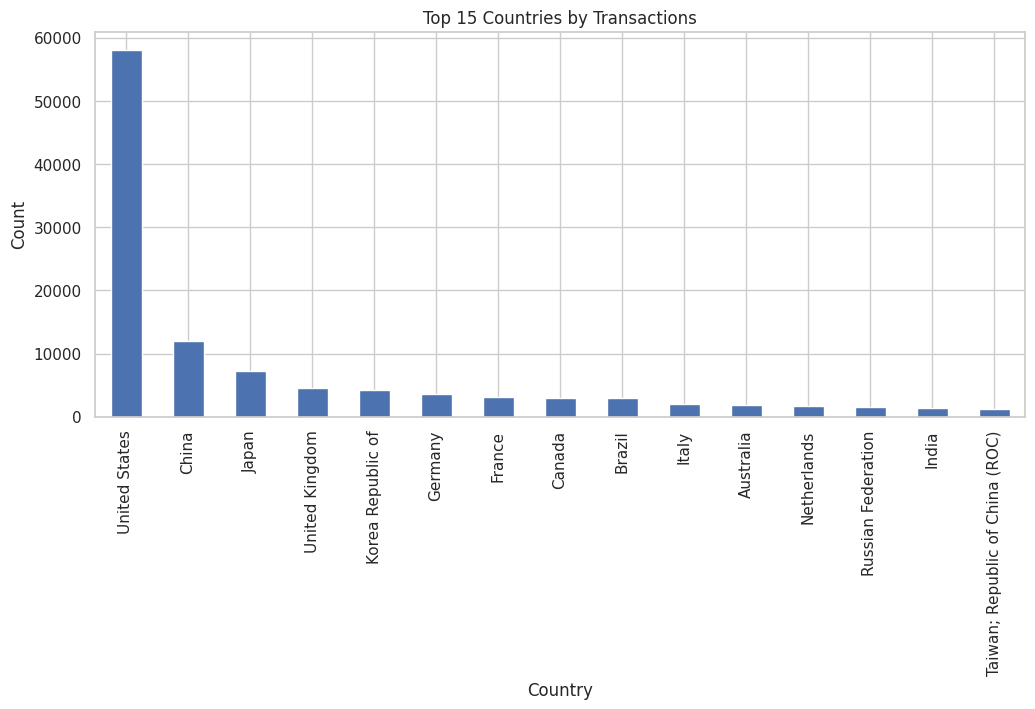

In [ ]:
# Set style
sns.set(style="whitegrid")

# 1. Country distribution (Top 15)
plt.figure(figsize=(12,5))
data['country'].value_counts().head(15).plot(kind='bar')
plt.title("Top 15 Countries by Transactions")
plt.xlabel("Country")
plt.ylabel("Count")
plt.show()


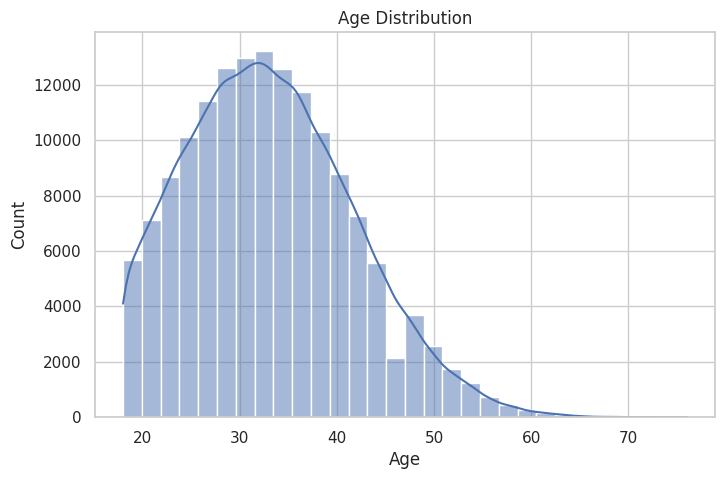

In [ ]:
# 2. Age distribution of users
plt.figure(figsize=(8,5))
sns.histplot(data['age'], bins=30, kde=True)
plt.title("Age Distribution")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

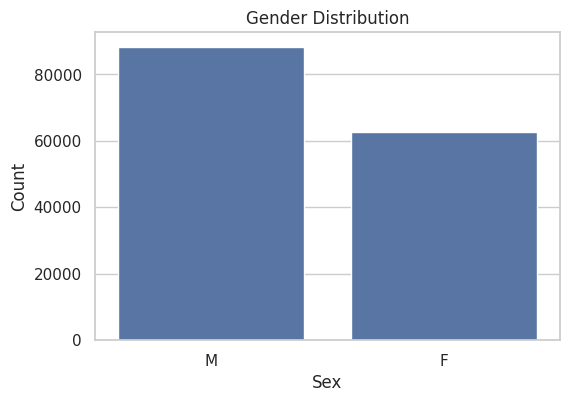

In [ ]:
# 3. Gender distribution
plt.figure(figsize=(6,4))
sns.countplot(x='sex', data=data)
plt.title("Gender Distribution")
plt.xlabel("Sex")
plt.ylabel("Count")
plt.show()

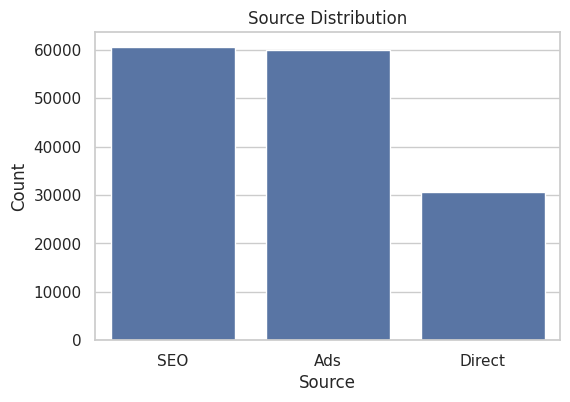

In [ ]:
# 4. Source distribution
plt.figure(figsize=(6,4))
sns.countplot(x='source', data=data, order=data['source'].value_counts().index)
plt.title("Source Distribution")
plt.xlabel("Source")
plt.ylabel("Count")
plt.show()

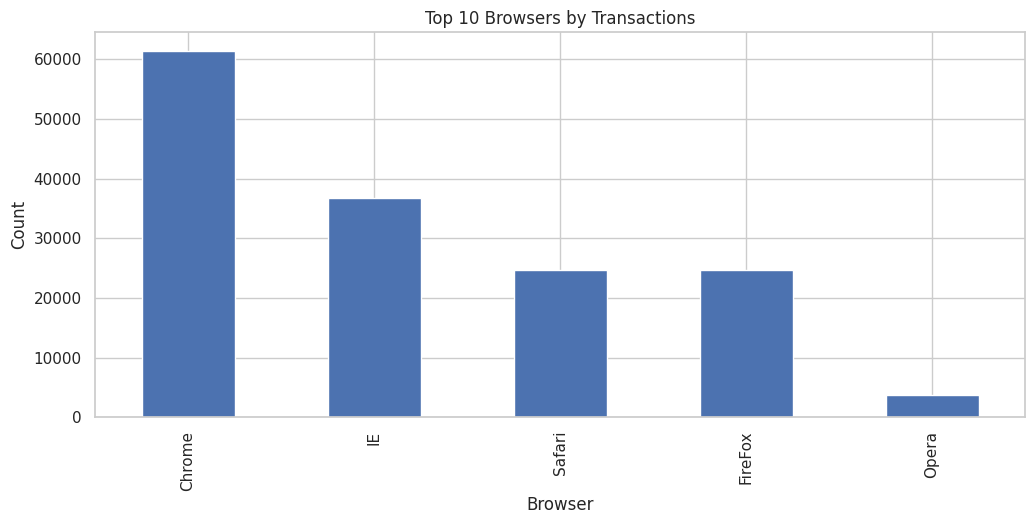

In [ ]:
# 5. Browser usage distribution
plt.figure(figsize=(12,5))
data['browser'].value_counts().head(10).plot(kind='bar')
plt.title("Browsers by Transactions")
plt.xlabel("Browser")
plt.ylabel("Count")
plt.show()

## Visualizing Fraud vs Non-Fraud Patterns

In [ ]:
# Convert to datetime
data['signup_time'] = pd.to_datetime(data['signup_time'])
data['purchase_time'] = pd.to_datetime(data['purchase_time'])

# Extract time-related features
data['signup_hour'] = data['signup_time'].dt.hour
data['signup_dayofweek'] = data['signup_time'].dt.dayofweek  # 0=Monday, 6=Sunday
data['purchase_hour'] = data['purchase_time'].dt.hour
data['purchase_dayofweek'] = data['purchase_time'].dt.dayofweek

# Create new feature: time difference between signup and purchase (in minutes)
data['time_diff_minutes'] = (data['purchase_time'] - data['signup_time']).dt.total_seconds() / 60

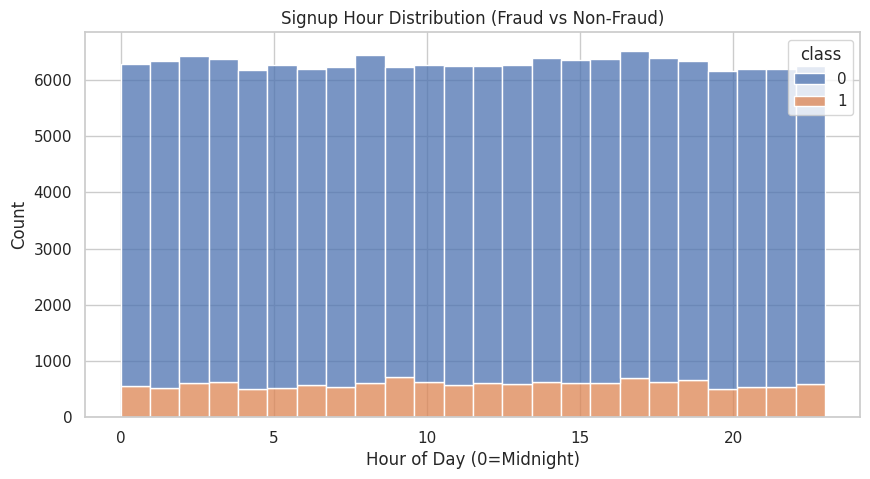

In [ ]:
# 1. Signup Hour distribution (stacked by fraud class)
plt.figure(figsize=(10,5))
sns.histplot(data=data, x='signup_hour', hue='class', multiple='stack', bins=24)
plt.title("Signup Hour Distribution (Fraud vs Non-Fraud)")
plt.xlabel("Hour of Day (0=Midnight)")
plt.ylabel("Count")
plt.show()

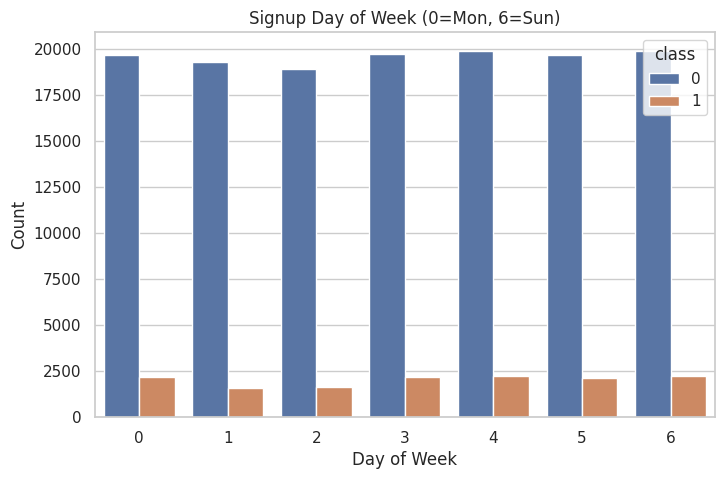

In [ ]:
# 2. Signup Day of Week distribution
plt.figure(figsize=(8,5))
sns.countplot(x='signup_dayofweek', hue='class', data=data)
plt.title("Signup Day of Week (0=Mon, 6=Sun)")
plt.xlabel("Day of Week")
plt.ylabel("Count")
plt.show()



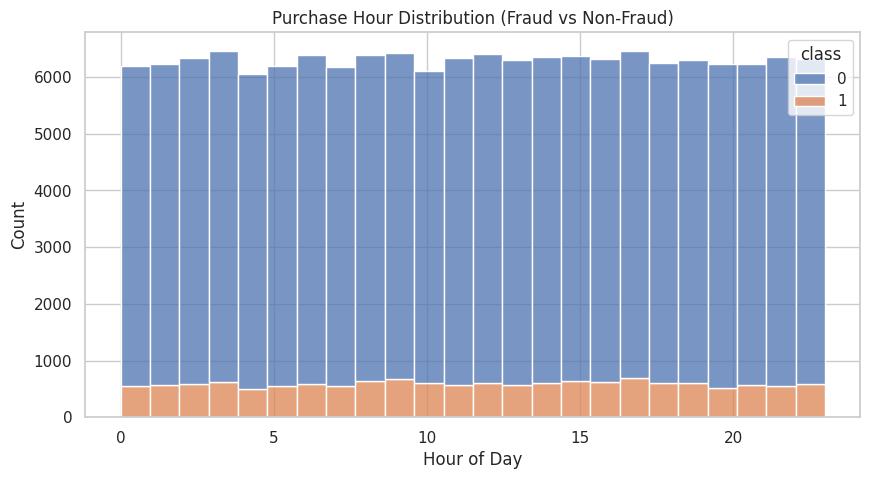

In [ ]:
# 3. Purchase Hour distribution
plt.figure(figsize=(10,5))
sns.histplot(data=data, x='purchase_hour', hue='class', multiple='stack', bins=24)
plt.title("Purchase Hour Distribution (Fraud vs Non-Fraud)")
plt.xlabel("Hour of Day")
plt.ylabel("Count")
plt.show()



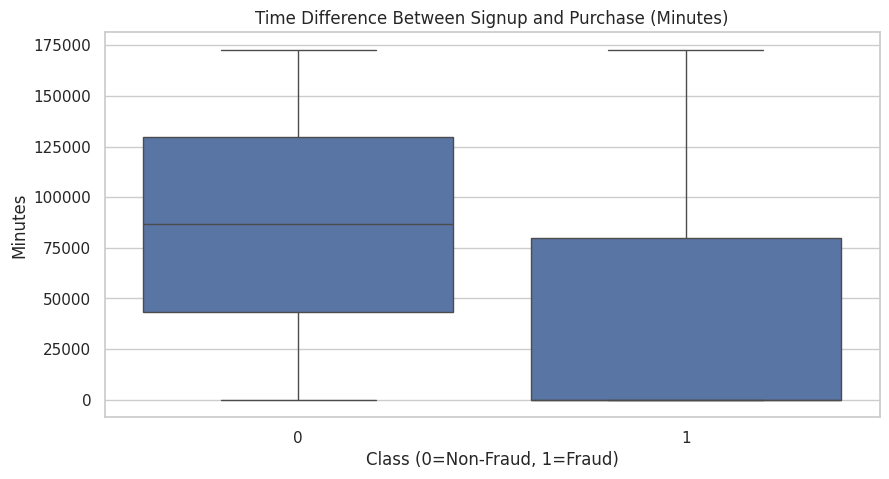

In [ ]:
# 4. Time difference between signup and purchase (boxplot by class)
plt.figure(figsize=(10,5))
sns.boxplot(x='class', y='time_diff_minutes', data=data, showfliers=False)
plt.title("Time Difference Between Signup and Purchase (Minutes)")
plt.xlabel("Class (0=Non-Fraud, 1=Fraud)")
plt.ylabel("Minutes")
plt.show()

## Class Distribution (Fraud vs Non-Fraud)

Class distribution:
class
0    136961
1     14151
Name: count, dtype: int64


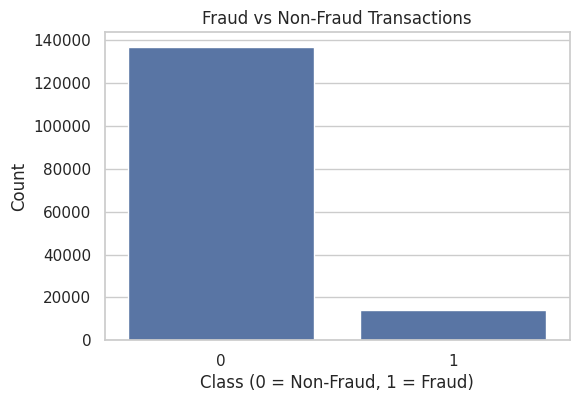

Fraud cases represent 9.36% of the dataset.


In [ ]:
# Count of each class
class_counts = data['class'].value_counts()
print("Class distribution:")
print(class_counts)

# Plot fraud vs non-fraud counts
plt.figure(figsize=(6,4))
sns.countplot(x='class', data=data)
plt.title("Fraud vs Non-Fraud Transactions")
plt.xlabel("Class (0 = Non-Fraud, 1 = Fraud)")
plt.ylabel("Count")
plt.show()

# Percentage of fraud
fraud_percentage = (class_counts[1] / class_counts.sum()) * 100
print(f"Fraud cases represent {fraud_percentage:.2f}% of the dataset.")

# Data Preprocessing

In [ ]:
# Drop identifiers and datetime columns
X = data.drop(columns=['class', 'signup_time', 'purchase_time', 'user_id', 'device_id', 'ip_address'])

# One-hot encode categorical variables
X = pd.get_dummies(X, drop_first=True)  # drop_first=True avoids multicollinearity

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, data['class'],
    test_size=0.3,
    random_state=42,
    stratify=data['class']
)

print("Shapes after encoding:", X_train.shape, X_test.shape)

Shapes after encoding: (105778, 194) (45334, 194)


## Logistic Regression Model

In [ ]:
def run_logistic_regression(X_train, y_train, X_test, y_test):
    """
    Train and evaluate a Logistic Regression model for fraud detection.
    """

    model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for ROC/PR curves

    # Evaluation
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("ROC-AUC:", roc_auc_score(y_test, y_proba))

    # Precision-Recall Curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision)
    print("PR-AUC:", pr_auc)

    # Plot Precision-Recall Curve
    plt.figure(figsize=(6,5))
    plt.plot(recall, precision, marker='.')
    plt.title("Precision-Recall Curve (Logistic Regression)")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.show()

    return model

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.64      0.77     41089
           1       0.17      0.70      0.27      4245

    accuracy                           0.65     45334
   macro avg       0.56      0.67      0.52     45334
weighted avg       0.88      0.65      0.72     45334

Confusion Matrix:
 [[26373 14716]
 [ 1287  2958]]
ROC-AUC: 0.7519109843463417
PR-AUC: 0.41584439507641185


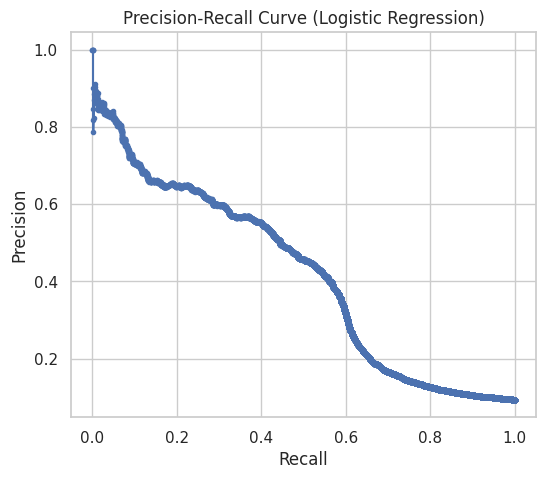

In [ ]:
log_reg_model = run_logistic_regression(X_train, y_train, X_test, y_test)

## Random Forest Model

In [ ]:
def run_random_forest(X_train, y_train, X_test, y_test):
    """
    Train and evaluate a Random Forest model for fraud detection.
    """
    model = RandomForestClassifier(
        n_estimators=200,       # number of trees
        max_depth=None,        # allow trees to grow fully
        class_weight='balanced', # handle imbalance
        random_state=42,
        n_jobs=-1              # use all CPUs
    )

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # Evaluation
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("ROC-AUC:", roc_auc_score(y_test, y_proba))

    # Precision-Recall Curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision)
    print("PR-AUC:", pr_auc)

    # Plot Precision-Recall Curve
    plt.figure(figsize=(6,5))
    plt.plot(recall, precision, marker='.')
    plt.title("Precision-Recall Curve (Random Forest)")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.show()

    return model

Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.98     41089
           1       1.00      0.53      0.70      4245

    accuracy                           0.96     45334
   macro avg       0.98      0.77      0.84     45334
weighted avg       0.96      0.96      0.95     45334

Confusion Matrix:
 [[41087     2]
 [ 1982  2263]]
ROC-AUC: 0.767709781413044
PR-AUC: 0.6259471187785427


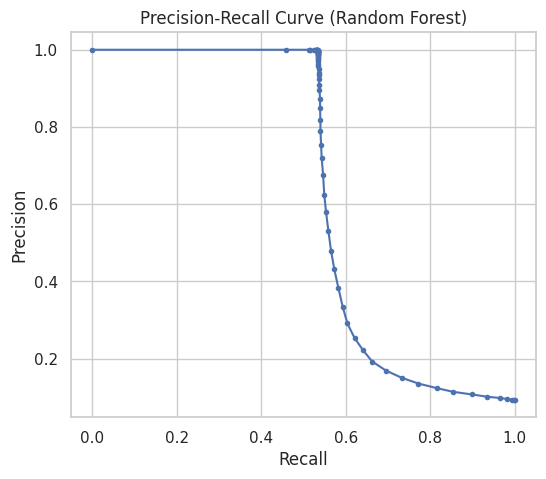

In [ ]:
rf_model = run_random_forest(X_train, y_train, X_test, y_test)

## XGBoost Model

In [ ]:
def run_xgboost(X_train, y_train, X_test, y_test):
    """
    Train and evaluate an XGBoost model for fraud detection.
    """
    model = XGBClassifier(
        n_estimators=300,       # number of boosting rounds
        learning_rate=0.1,      # step size shrinkage
        max_depth=6,            # max depth of each tree
        subsample=0.8,          # prevent overfitting
        colsample_bytree=0.8,   # feature sampling
        scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train), # handle imbalance
        random_state=42,
        n_jobs=-1,
        use_label_encoder=False,
        eval_metric='logloss'
    )

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # Evaluation
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("ROC-AUC:", roc_auc_score(y_test, y_proba))

    # Precision-Recall Curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision)
    print("PR-AUC:", pr_auc)

    # Plot Precision-Recall Curve
    plt.figure(figsize=(6,5))
    plt.plot(recall, precision, marker='.')
    plt.title("Precision-Recall Curve (XGBoost)")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.show()

    return model

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [11:25:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97     41089
           1       0.84      0.54      0.66      4245

    accuracy                           0.95     45334
   macro avg       0.90      0.76      0.81     45334
weighted avg       0.94      0.95      0.94     45334

Confusion Matrix:
 [[40655   434]
 [ 1956  2289]]
ROC-AUC: 0.7696868021357643
PR-AUC: 0.6237728281241953


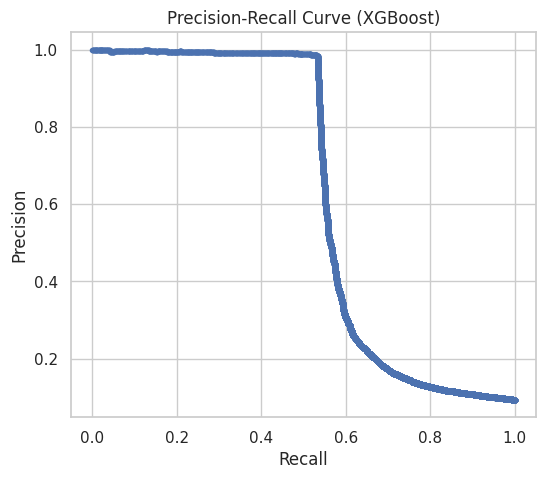

In [ ]:
xgb_model = run_xgboost(X_train, y_train, X_test, y_test)

## Isolation Forest

In [ ]:
def run_isolation_forest(X_train, y_train, X_test, y_test):
    """
    Train and evaluate an Isolation Forest for fraud detection.
    """
    model = IsolationForest(
        n_estimators=200,
        contamination=y_train.mean(),  # expected proportion of fraud in data
        random_state=42,
        n_jobs=-1
    )

    model.fit(X_train)

    # Convert predictions (-1 anomaly → fraud, 1 normal → non-fraud)
    y_pred_iso = model.predict(X_test)
    y_pred = [1 if p == -1 else 0 for p in y_pred_iso]

    # Anomaly scores (higher = more anomalous)
    y_score = -model.decision_function(X_test)  # higher = more anomalous

    # Evaluation
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("ROC-AUC:", roc_auc_score(y_test, y_score))

    precision, recall, thresholds = precision_recall_curve(y_test, y_score)
    pr_auc = auc(recall, precision)
    print("PR-AUC:", pr_auc)

    # Plot Precision-Recall Curve
    plt.figure(figsize=(6,5))
    plt.plot(recall, precision, marker='.')
    plt.title("Precision-Recall Curve (Isolation Forest)")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.show()

    return model

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.91      0.91     41089
           1       0.12      0.12      0.12      4245

    accuracy                           0.84     45334
   macro avg       0.52      0.52      0.52     45334
weighted avg       0.84      0.84      0.84     45334

Confusion Matrix:
 [[37419  3670]
 [ 3728   517]]
ROC-AUC: 0.5505176344343276
PR-AUC: 0.10971531897059678


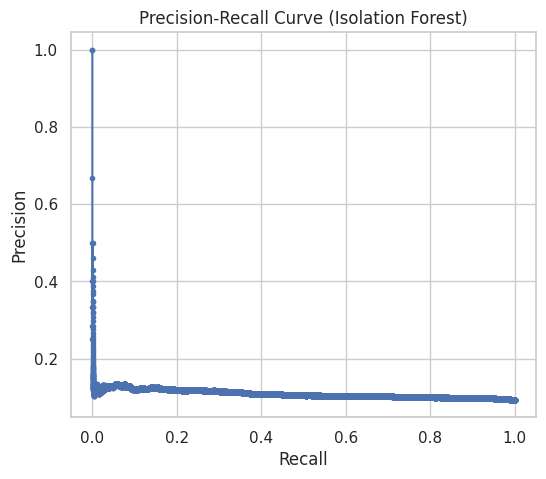

In [ ]:
iso_model = run_isolation_forest(X_train, y_train, X_test, y_test)

## Autoencoder

In [ ]:
def run_autoencoder(X_train, y_train, X_test, y_test, epochs=20, batch_size=256):
    """
    Train and evaluate an Autoencoder for fraud detection.
    """
    input_dim = X_train.shape[1]

    # Scale features for neural network
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Autoencoder architecture (encoder → bottleneck → decoder)
    input_layer = layers.Input(shape=(input_dim,))
    encoded = layers.Dense(64, activation="relu")(input_layer)
    encoded = layers.Dense(32, activation="relu")(encoded)
    bottleneck = layers.Dense(16, activation="relu")(encoded)
    decoded = layers.Dense(32, activation="relu")(bottleneck)
    decoded = layers.Dense(64, activation="relu")(decoded)
    output_layer = layers.Dense(input_dim, activation="linear")(decoded)

    autoencoder = models.Model(inputs=input_layer, outputs=output_layer)
    autoencoder.compile(optimizer="adam", loss="mse")

    # Train Autoencoder only on NON-FRAUD cases (class=0)
    X_train_normal = X_train_scaled[y_train == 0]

    history = autoencoder.fit(
        X_train_normal, X_train_normal,
        epochs=epochs,
        batch_size=batch_size,
        shuffle=True,
        validation_split=0.1,
        verbose=0
    )

    # Reconstruction error on test set
    X_test_pred = autoencoder.predict(X_test_scaled)
    mse = np.mean(np.square(X_test_scaled - X_test_pred), axis=1)

    # Choose threshold = 95th percentile of reconstruction error on training normal data
    X_train_pred = autoencoder.predict(X_train_normal)
    mse_train = np.mean(np.square(X_train_normal - X_train_pred), axis=1)
    threshold = np.percentile(mse_train, 95)

    # Predictions
    y_pred = (mse > threshold).astype(int)

    # Evaluation
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("ROC-AUC:", roc_auc_score(y_test, mse))

    precision, recall, thresholds = precision_recall_curve(y_test, mse)
    pr_auc = auc(recall, precision)
    print("PR-AUC:", pr_auc)

    # Plot Precision-Recall Curve
    plt.figure(figsize=(6,5))
    plt.plot(recall, precision, marker='.')
    plt.title("Precision-Recall Curve (Autoencoder)")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.show()

    return autoencoder, scaler, threshold

1417/1417 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
2996/2996 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.95      0.93     41089
           1       0.12      0.06      0.08      4245

    accuracy                           0.87     45334
   macro avg       0.51      0.51      0.51     45334
weighted avg       0.83      0.87      0.85     45334

Confusion Matrix:
 [[39006  2083]
 [ 3974   271]]
ROC-AUC: 0.5377989936579681
PR-AUC: 0.10306887339351178


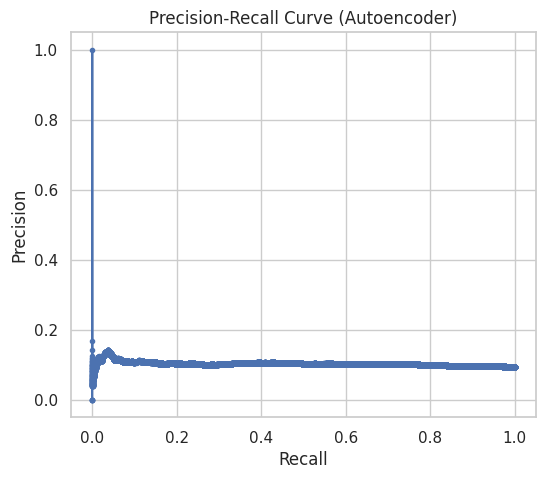

In [ ]:
autoencoder_model, scaler, threshold = run_autoencoder(X_train, y_train, X_test, y_test)

# Resampling with SMOTE

In [ ]:
# Apply SMOTE only on training set
smote = SMOTE(random_state=42)

X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_smote.value_counts())

Before SMOTE: class
0    95872
1     9906
Name: count, dtype: int64
After SMOTE: class
0    95872
1    95872
Name: count, dtype: int64


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.69      0.80     41089
           1       0.17      0.63      0.27      4245

    accuracy                           0.69     45334
   macro avg       0.56      0.66      0.54     45334
weighted avg       0.87      0.69      0.75     45334

Confusion Matrix:
 [[28501 12588]
 [ 1590  2655]]
ROC-AUC: 0.6993206421602955
PR-AUC: 0.2219077208805384


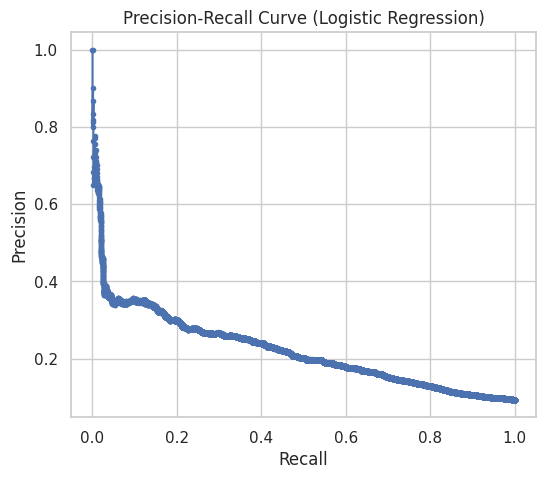

In [ ]:
# Logistic Regression with SMOTE
log_reg_model_smote = run_logistic_regression(X_train_smote, y_train_smote, X_test, y_test)

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97     41089
           1       0.84      0.54      0.66      4245

    accuracy                           0.95     45334
   macro avg       0.90      0.77      0.82     45334
weighted avg       0.94      0.95      0.94     45334

Confusion Matrix:
 [[40664   425]
 [ 1950  2295]]
ROC-AUC: 0.7716513674917682
PR-AUC: 0.6291079468503279


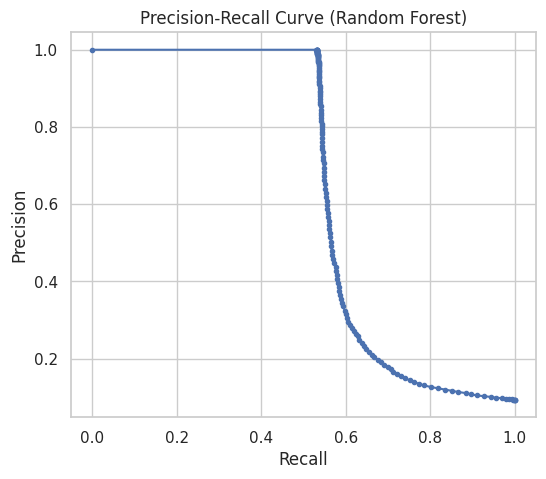

In [ ]:
# Random Forest with SMOTE
rf_model_smote = run_random_forest(X_train_smote, y_train_smote, X_test, y_test)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [11:31:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.98      0.97     41089
           1       0.77      0.54      0.64      4245

    accuracy                           0.94     45334
   macro avg       0.86      0.76      0.80     45334
weighted avg       0.94      0.94      0.94     45334

Confusion Matrix:
 [[40400   689]
 [ 1937  2308]]
ROC-AUC: 0.7729437472353458
PR-AUC: 0.6253811735597955


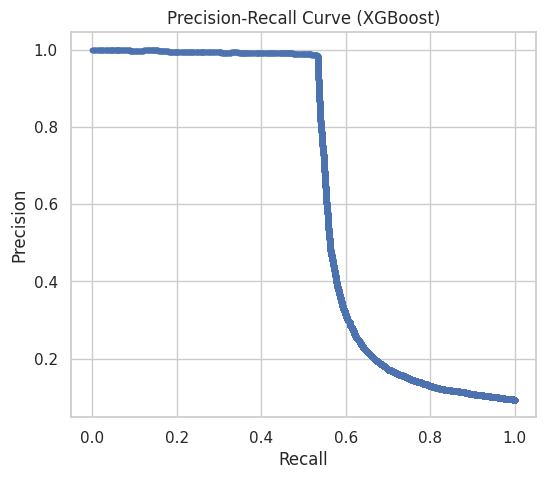

In [ ]:
# XGBoost with SMOTE
xgb_model_smote = run_xgboost(X_train_smote, y_train_smote, X_test, y_test)

# Feature Importance Analysis

In [ ]:
# Logistic Regression coefficients
coeffs = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': log_reg_model.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

print(coeffs.head(10))  # Top 10 features

                    Feature  Coefficient
7             source_Direct     0.268506
183  country_United Kingdom     0.132273
45           country_Canada     0.095378
9           browser_FireFox     0.083831
8                source_SEO     0.080040
86        country_Hong Kong     0.058697
120          country_Mexico     0.057684
184   country_United States     0.057223
13                    sex_M     0.054812
133     country_New Zealand     0.043622


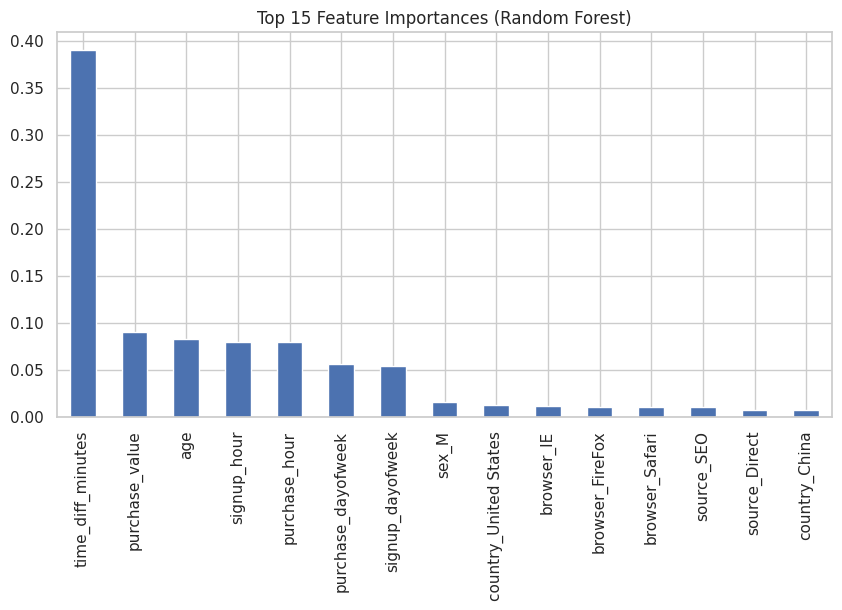

In [ ]:
# Random Forest feature importances
importances = rf_model.feature_importances_
feat_imp = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(10,5))
feat_imp.head(15).plot(kind='bar')
plt.title("Top 15 Feature Importances (Random Forest)")
plt.show()

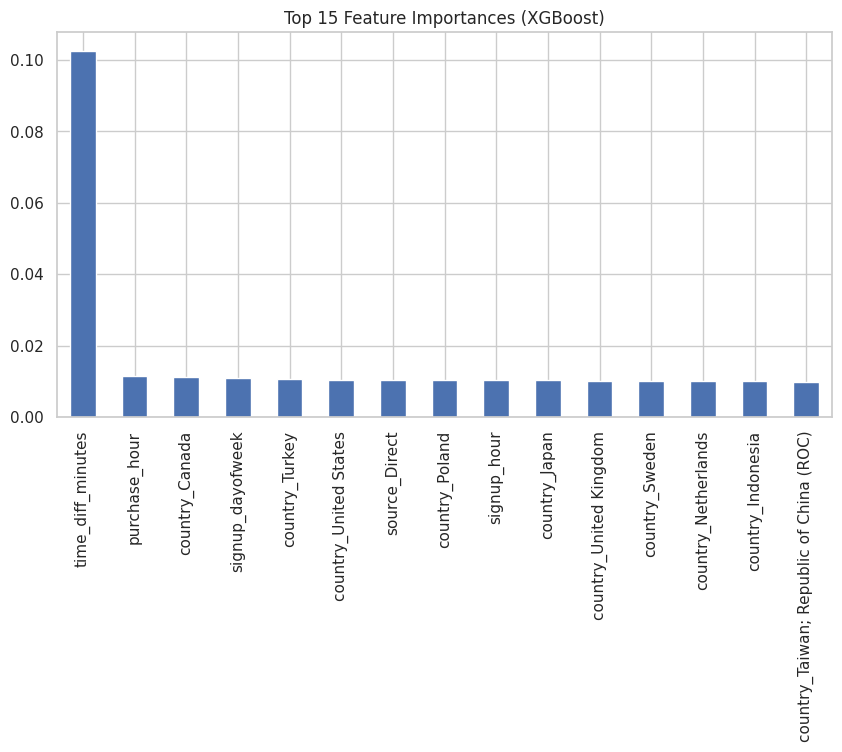

In [ ]:
# XGBoost feature importances
xgb_importances = xgb_model.feature_importances_
feat_imp_xgb = pd.Series(xgb_importances, index=X_train.columns).sort_values(ascending=False)

plt.figure(figsize=(10,5))
feat_imp_xgb.head(15).plot(kind='bar')
plt.title("Top 15 Feature Importances (XGBoost)")
plt.show()

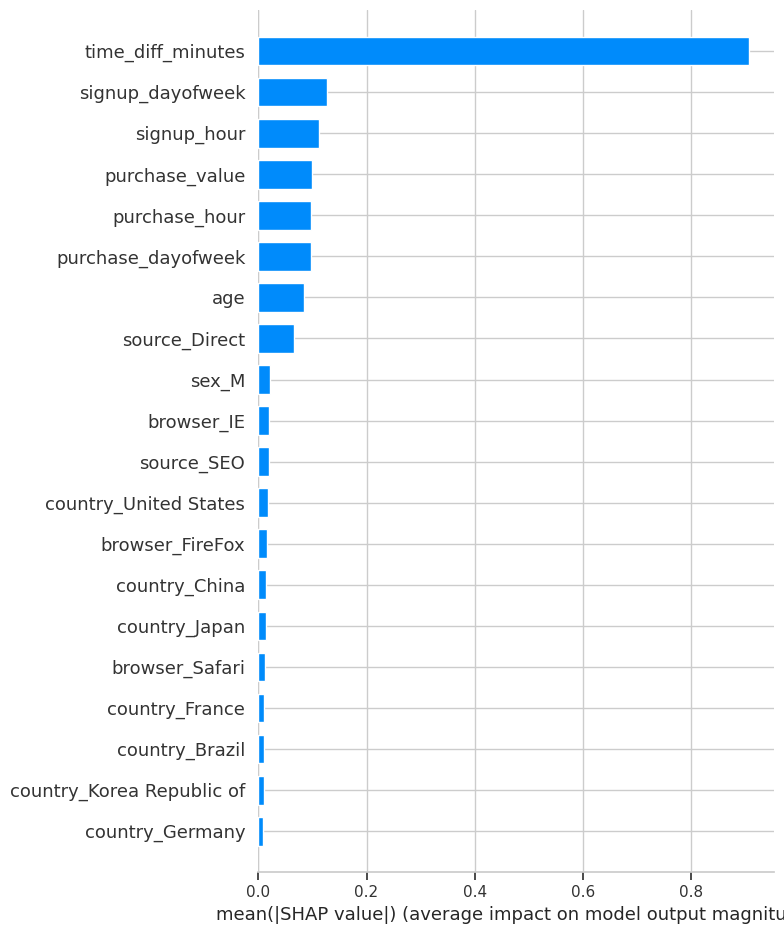

In [ ]:
# SHAP values (explainability for XGBoost)
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)


# SHAP summary plot
shap.summary_plot(shap_values, X_test, plot_type="bar")